# Word2Vec

# Skip-Gram Model - Negative Sampling

## Table of Contents

1. **[Import Corpus for inspection](#import_corpus)**

    - [Corpus sample](#corpus_sample)    
    
2. **[Vocabulary word-ID mappings](#word2id)**

3. **[Negative Sampling](#neg_sampling)**

4. **[Generate training samples](#generate_samples)**

5. **[Loss Function](#loss)**

6. **[SkipGram model - Negative Sampling](#model)**

7. **[Train the model](#train_model)**

8. **[Evaluate Embeddings quality](#eval_embeds)**

Adapted from: <br>
https://adoni.github.io/2017/11/08/word2vec-pytorch/ <br>
https://github.com/Adoni/word2vec_pytorch/blob/master/model.py <br>
https://github.com/fanglanting/skip-gram-pytorch/blob/master/model.py<br>
http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/<br>
http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/ <br>
https://github.com/udacity/deep-learning/blob/master/embeddings/Skip-Grams-Solution.ipynb <br>
https://towardsdatascience.com/implementing-word2vec-in-pytorch-skip-gram-model-e6bae040d2fb - (good intuition on what the softmax is doing)
https://gist.github.com/lirnli/c6e02efc414b4473abbb8152d303514c <br>
https://github.com/LianHaiMiao/pytorch-lesson-zh/blob/master/NLP/py/word2vec.py <br>
http://ruder.io/word-embeddings-softmax/ <br>
https://arxiv.org/pdf/1411.2738.pdf

In [1]:
import os
from time import time
%matplotlib inline
%load_ext memory_profiler
import itertools
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from collections import deque
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import functional as F

from glob import glob
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en')
from nltk.tokenize import word_tokenize
from nltk import FreqDist

/home/hveiga/Desktop/Data_Science/dl-venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hveiga/Desktop/Data_Science/dl-venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hveiga/Desktop/Data_Science/dl-venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/home/hveiga/Desktop/Data_Science/dl-venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hveiga/Desktop/Data_Science/dl-venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibi

<a id='import_corpus'></a>
## Import corpus for inspection

In [2]:
path = './aclImdb/train/pos/*.txt'
text = ""

for filename in glob(path):
    with open(filename,'r') as f:
        text += " " + f.read()
              
#with open("./aclImdb/corpus_all_pos.txt", "w+") as f:
#    f.write(text[:75000])
#    f.close()

In [3]:
corpus = [token.text for token in list(nlp.tokenizer(text[:50000]))]
# stop_words = set(stopwords.words('english'))
# corpus = [w for w in corpus if w not in stop_words]

<a id='corpus_sample'></a>
### Corpus sample

In [4]:
print('length of texts: ', len(corpus))
print('number of unique words:', len(set(corpus)))
print('a sample below')
corpus[:10]

length of texts:  10308
number of unique words: 2766
a sample below


[' ', 'I', "'m", 'grateful', 'to', 'Cesar', 'Montano', 'and', 'his', 'crew']

### 20 most frequent words (tokens)

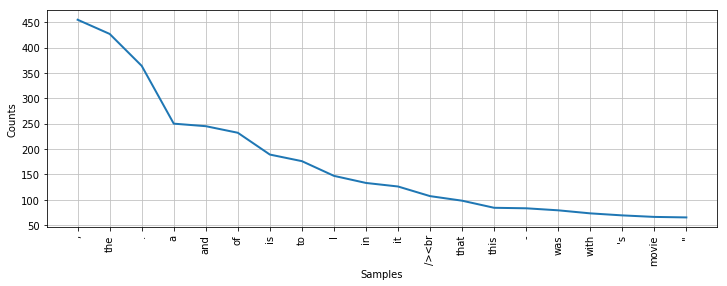

In [5]:
dist = FreqDist(corpus)
dist.most_common(20)
plt.figure(figsize=[12,4])
dist.plot(20)

In [6]:
words_occurred_only_once = [w for w in dist.most_common() if w[1]==1]
print('number of words occurred only once', len(words_occurred_only_once))

number of words occurred only once 1862


### Frequency with respects to word count

In the plot below, most words in the vocabulary occurrs less than 5 times.

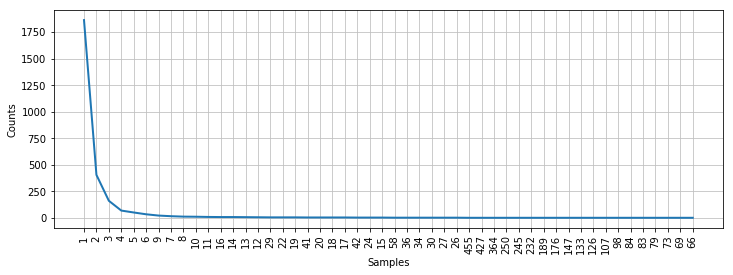

In [7]:
occurr_dist = FreqDist([w[1] for w in dist.most_common()])
plt.figure(figsize=[12,4])
occurr_dist.plot(50)

In [8]:
percent = sum([w[1] for w in occurr_dist.most_common() if w[1]<=5])/sum([w[1] for w in occurr_dist.most_common()])
print('words occurred <= 5 times in corpus:',percent)

words occurred <= 5 times in corpus: 0.030730296456977585


<a id='word2id'></a>
## Vocabulary word-ID mappings

In [9]:
# Word frequency
word_frequency = dict(FreqDist(corpus))

In [10]:
# Word - ID mapping
word2id = {}
for filename in glob(path):
    with open(filename,'r') as f:      
        for line in f: 
            tokens = word_tokenize(line)

            if word2id:
                word2id.update({word:0 for word in tokens})
            else:
                word2id = {word:0 for word in tokens}

for i, (word, value) in enumerate(list(word2id.items())):
    word2id[word] = i

In [11]:
id2word = {i: word for word, i in word2id.items()}
#word_count = len(word2id)

<a id='neg_sampling'></a>
## Negative Sampling

The “negative samples” (that is, the c output words that we’ll train to output 0) are chosen using a “unigram distribution”.

Essentially, the probability for selecting a word as a negative sample is related to its frequency, with more frequent words being more likely to be selected as negative samples.

In the word2vec C implementation, you can see the equation for this probability. Each word is given a weight equal to it’s frequency (word count) raised to the 3/4 power. The probability for a selecting a word is just it’s weight divided by the sum of weights for all words:

$$P(w_i) = \frac{  {f(w_i)}^{3/4}  }{\sum_{j=0}^{n}\left(  {f(w_j)}^{3/4} \right) }$$

In [12]:
# Probability for a given word i in the corpus
pow_frequency = np.array(list(word_frequency.values()))**0.75
words_pow = sum(pow_frequency) 
p_wi = pow_frequency / words_pow

This is the way Word2Vec C code implemented choosing negative samples. <br>
They have a large array with 100M elements (which they refer to as the unigram table). They fill this table with the index of each word in the vocabulary multiple times - the number of times a word’s index appears in the table is given by **P(wi) * table_size**. <br>
Then, to actually select a negative sample, you just generate a random integer between 0 and 100M, and use the word at that index in the table. <br>
Since the higher probability words occur more times in the table, you’re more likely to pick those.

Source: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/

In [13]:
sample_table = []
sample_table_size = 1e8 # empty 100 million array

# Generate "unigram" table
count = np.round(p_wi * sample_table_size) # number of times a word’s index will appear in the table

# Fill the table 
for wid, c in enumerate(count):
    sample_table += [wid] * int(c)
    
sample_table = np.array(sample_table)

#### Class to generate samples

This will generate 3 matrices: <br><br>
**center_words** - list of center (input) word IDs - batch x 1 <br>
**positive_words** - list of positive context (neighbour) word IDs - batch x 1 <br>
**negative_words** - list of negative words IDs (not in the specified window size) - batch x context size

<a id='generate_samples'></a>
## Generate training samples

In [14]:
class GenerateDataset(Dataset):
    def __init__(self, window_size, vocab_map, sample_table, n_docs, transform=None, random_seed=777):
        
        word_pair_catch = deque()
        word_ids = []
        self.center_words = []
        self.positive_words = []
        self.transform = transform
        
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
                
        for filename in glob(path)[:n_docs]:
            with open(filename,'r') as f:
                for line in f:
                    word_ids = []
                    for word in word_tokenize(line):
                        word_ids.append(vocab_map[word])

                    for i, u in enumerate(word_ids):
                        for j, v in enumerate(
                                word_ids[max(i - window_size + 1, 0):i + window_size + 1]):            
                            if i == j:
                                continue
                            word_pair_catch.append((u, v))

                    for _ in range(len(word_pair_catch)):
                        _pair = word_pair_catch.popleft()

                        self.center_words.append(_pair[0])
                        self.positive_words.append(_pair[1])

                    self.neg_words = np.random.choice(
                        sample_table, size=((len(self.center_words)), window_size))

                        
    def __getitem__(self, index):
        if self.transform:
            self.center_words = np.array(self.center_words).reshape(-1,1)
            self.positive_words = np.array(self.positive_words).reshape(-1,1)
            self.neg_words = np.array(self.neg_words) 
            
            return self.transform(self.center_words[index], self.positive_words[index], self.neg_words[index])

    def __len__(self):
        return len(self.center_words)

In [15]:
class ToTensor(object):
    def __call__(self, center_words, positive_words, neg_words):
        center_words = torch.from_numpy(center_words)
        positive_words = torch.from_numpy(positive_words)
        negative_words = torch.from_numpy(neg_words)       
        
        return center_words, positive_words, negative_words

<a id='loss'></a>
## Loss Function

The **Negative Sampling Loss** to be used is given by:

$$ \frac{1}{T}  \sum_{t=1}^T  \: \sum_{-c<=j<c, j\neq0} \:\text{log} \: p( {w_{t+j}|w_{t}} ) $$ 

$$ Where: \text{log} \: p( {w_{t+j}|w_{t}} ) = J_\theta $$ 

$$J_\theta = \sum_{w_i \in V} [ \text{log} \: \sigma(h \times v_{w_O}^\top ) + \: \sum_{j=1}^k \:\text{log} \: \sigma(h \times -v_{w_j}^\top)]$$ 

Sources: <br>
https://arxiv.org/pdf/1411.2738.pdf <br>
https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf

Where: $$w_1, w_2, w_3, \cdots, w_T$$ Are a sequence of T training words that belong to a vocabulary V. <br> 
$$h$$ Is the input word embedding indexed from the embedding matrix with d dimensions. <br>
$$v_{w_O}$$ Is the output vector (embedding vector) for the output word (positive context target word) 
$$v_{w_j}$$ Is the output vector (embedding vector) for the output word (from j=1 to k negative context words) 

The formula is adapted for the matrix shapes used in this notebook (x denotes batch matrix multiplication)

<a id='model'></a>
## SkipGram model - Negative Sampling

In [57]:
random_seed = 777
batch_size = 256
emb_dimension = 3
window_size = 5
n_epochs = 10
learning_rate = 0.01
vocab_size = len(word2id)
n_docs = 20

#### Create samples for training and place it in batches

In [58]:
imdb_dataset = GenerateDataset(window_size, word2id, sample_table, n_docs, ToTensor(), random_seed)

In [59]:
imdb_loader = DataLoader(imdb_dataset, 
                         batch_size=batch_size, 
                         shuffle=False,
                         num_workers=0, 
                         drop_last=True)

#### Architecture
- Cross entropy here corresponds to binary cross entropy because our target will be 1/0 and not a probability distributiom as given by softmax
- Instead of the whole vocabulary we'll have for each input/positive context word pair, K negative context words

<img style="float: left;" src="skip_gram_image.jpg">

In [60]:
class SkipGram_NegSamp_Model(nn.Module):
    def __init__(self, vocab_size, emb_dimension, random_seed):
        super(SkipGram_NegSamp_Model, self).__init__()
        self.random_seed = random_seed
        self.emb_dimension = emb_dimension
        self.center_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=True)
        self.context_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=True)
        self.init_emb()
        
    def init_emb(self):
        """Initialize embedding weights like word2vec.
        The u_embedding is a uniform distribution in [-0.5/em_size, 0.5/emb_size], 
        and the elements of v_embedding are zeros.
        """        
        torch.manual_seed(self.random_seed)
        initrange = 0.5 / self.emb_dimension
        self.center_embeddings.weight.data.uniform_(-initrange, initrange)
        self.context_embeddings.weight.data.uniform_(-0, 0)

    def forward(self, center_words, positive_words, negative_words):       

        center_embeds = self.center_embeddings(center_words)      # Batch x 1 x Emb Dim
        positive_embeds = self.context_embeddings(positive_words) # Batch x 1 x Emb Dim
        neg_embeds = - self.context_embeddings(negative_words)    # Batch x window_size x Emb Dim                                   

        positive_score = torch.bmm(center_embeds, 
                                   positive_embeds.transpose(1,2)).squeeze(-1) # Batch x 1
        positive_score = F.logsigmoid(positive_score)
        
        #positive_score = torch.mul(center_embeds, positive_embeds).squeeze()
        #positive_score = torch.sum(positive_score, dim=1).unsqueeze(1) # This approach is way slower but uses less code

        negative_score = torch.bmm(center_embeds, 
                                        neg_embeds.transpose(1,2)).squeeze(1) # Batch x window_size
        negative_score = F.logsigmoid(negative_score)
        negative_score = torch.sum(negative_score, 1).unsqueeze(1)
        
        loss = positive_score + negative_score

        return - torch.mean(loss)
    
    def return_embeds(self):
        word_embeds = self.center_embeddings.weight.cpu().data.numpy()
        
        return word_embeds     

#### Instantiate model and optimizer

In [61]:
model = SkipGram_NegSamp_Model(vocab_size, emb_dimension, random_seed)
optimizer = torch.optim.SparseAdam(model.parameters(), lr=learning_rate)

#### Use GPU if available

In [62]:
if torch.cuda.is_available():
    model.cuda()

<a id='train_model'></a>
## Train the model

In [63]:
def train_model(n_epochs, data_loader, model):
    plot_train = []
    save_loss = []
    start_all = time()
    
    for epoch in range(n_epochs):
        start = time()
        losses = []
        for batch_idx, (center_words, positive_words, negative_words) in enumerate(data_loader):

            ##### Use GPU if available #####
            if torch.cuda.is_available():
                center_words = center_words.cuda()
                positive_words = positive_words.cuda()
                negative_words = negative_words.cuda()

            # forward, backward, optimize
            optimizer.zero_grad()        
            loss = model.forward(center_words, positive_words, negative_words)
            loss.backward()
            optimizer.step()                          

            # save loss
            losses.append(loss.item())
            
        end = time()
        save_loss.append(np.mean(losses))
        
        if epoch%1 == 0:
            print('epoch {}, epoch_loss {}, runtime {}'.format(epoch, np.mean(losses), end-start))

    
    pd.Series(save_loss).plot() 
    print("Total runtime is: " + str(time()-start_all) + " seconds")

epoch 0, epoch_loss 3.5827098167482228, runtime 21.864196062088013
epoch 1, epoch_loss 2.7114679416020713, runtime 21.508259296417236
epoch 2, epoch_loss 2.4117616871256886, runtime 21.867342948913574
epoch 3, epoch_loss 2.214143439084905, runtime 22.637658834457397
epoch 4, epoch_loss 2.059821254922529, runtime 20.990020751953125
epoch 5, epoch_loss 1.9379555904325634, runtime 20.96949338912964
epoch 6, epoch_loss 1.8443673461553, runtime 21.069066047668457
epoch 7, epoch_loss 1.7751728840816168, runtime 23.346020936965942
epoch 8, epoch_loss 1.725844974871035, runtime 22.429303884506226
epoch 9, epoch_loss 1.691459759027379, runtime 21.32530426979065
Total runtime is: 218.02469658851624 seconds


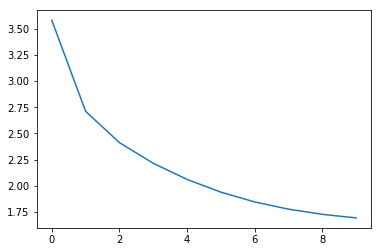

In [64]:
train_model(n_epochs, imdb_loader, model)

With **Negative sampling**, running the same 10 epochs, with 20 documents used, 3 dimensions in the embedding matrix AND with a context of 5 words (instead of the 3 used in the full softmax implementation) we are able to train in 1/5 of the time needed in the full softmax implementation (218 seconds vs 1121 seconds !)

<a id='eval_embeds'></a>
## Evaluate Embeddings quality

In [65]:
def get_encoding(word, word_dict, embedding):
    return embedding[word2id[word]]

In [66]:
def word_similarity(word1, word2):
    params = {"word_dict":word2id, 
              "embedding":model.return_embeds()}
    v1 = get_encoding(word1, **params)
    v2 = get_encoding(word2, **params)
    res = 1 - cosine(v1,v2)
    return res

In [67]:
def word_scatter(xs, labels,fontsize=14):
    for i, t in enumerate(labels):
        plt.annotate(t,xs[i],fontsize=fontsize)

In [68]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

#### Word similarity

Text(0.5,1,'PCA transformation of word vector')

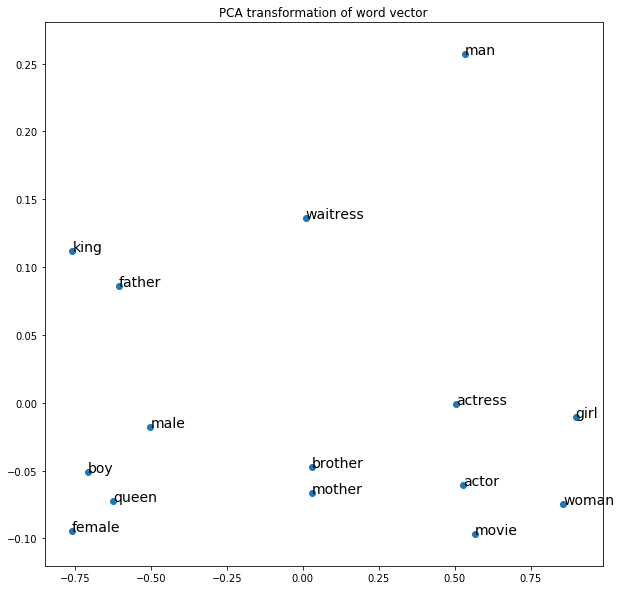

In [70]:
plt.figure(figsize=[10,10])
labels = 'man woman boy girl actor actress waitress male female movie father mother brother king queen'.split()

coords = [word2id[w] for w in labels]
coords = (model.return_embeds()[coords,:])

y_scatter = pca.fit_transform(coords)
plt.scatter(y_scatter[:,0], y_scatter[:,1])
word_scatter(y_scatter, labels)

plt.title('PCA transformation of word vector')

In [71]:
print('nice','good', word_similarity('nice','good'))
print('dog','cat', word_similarity('dog','cat'))
print('dog','animal', word_similarity('dog','animal'))
print('cat','animal', word_similarity('cat','animal'))
print('good','fantastic', word_similarity('good','fantastic'))
print('good','terrible', word_similarity('good','terrible'))
print('mother','father', word_similarity('mother','father'))
print('king','queen', word_similarity('king','queen'))
print('king','aunt', word_similarity('king','aunt'))
print('boy','girl', word_similarity('boy','girl'))
print('male','female', word_similarity('male','female'))
print('hate','love', word_similarity('hate','love'))
print('ugly','beautiful', word_similarity('ugly','beautiful'))
print('angry','happy', word_similarity('angry','happy'))
print('do','did', word_similarity('do','did'))
print('do','does', word_similarity('do','does'))
print('do','done', word_similarity('do','done'))

nice good 0.9184310436248779
dog cat 0.16394641995429993
dog animal -0.782575786113739
cat animal 0.39451807737350464
good fantastic 0.9026537537574768
good terrible 0.9314687252044678
mother father 0.4523323178291321
king queen -0.8747478723526001
king aunt -0.6790049076080322
boy girl -0.1729251742362976
male female -0.9010016918182373
hate love 0.23005308210849762
ugly beautiful 0.47067710757255554
angry happy 0.48282647132873535
do did 0.9951828718185425
do does 0.9956501722335815
do done 0.9654949903488159
